# Testing New Updates

This notebook is a proof-of-concept for the following features:
* Outcome Sampling for 
    * Location Conditioner
    * Discrete
* Testing the $X\mid Z$ functionality on 
    * contrived simulations
    * Realistic simulations with known ground truth

In [1]:
import sys
sys.path.append("../")  # go to parent dir
import jax
import jax.random as jr
import jax.numpy as jnp
jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF

from data.create_sim_data import generate_data_samples
import data.template_causl_simulations as causl_py
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 1000
causal_params = [0, 1]

In [2]:
def generate_data_samples(rscript):
    rcode_compiled = SignatureTranslatedAnonymousPackage(rscript, "powerpack")
    data_xdyc = rcode_compiled.data_samples

    # Extract JAX arrays from the dataframe
    Z_disc = jnp.array(data_xdyc[[col for col in data_xdyc.columns if col.startswith('Zd')]].values).astype(int)
    Z_cont = jnp.array(data_xdyc[[col for col in data_xdyc.columns if col.startswith('Zc')]].values)
    if Z_cont.size == 0:
        Z_cont = None
    if Z_disc.size == 0:
        Z_disc = None
    X = jnp.array(data_xdyc['X'].values)[:, None]
    Y = jnp.array(data_xdyc['Y'].values)[:, None]

    return {'Z_disc': Z_disc, 'Z_cont': Z_cont, 'X': X, 'Y': Y}
    
disc_rscript = f"""
library(causl)
forms <- list(list(Zd1 ~ 1), X ~ Zd1, Y ~ X, ~ 1)
fams <- list(c(5), 5, 1, 1)
pars <- list(Zd1 = list(beta=0, phi=1),
            X = list(beta=c(-1, 1)),
            Y = list(beta=c({causal_params[0]}, {causal_params[1]}), phi=0.5),
            cop = list(beta=matrix(c(0.8), nrow=1)))
set.seed({seed})
data_samples <- rfrugalParam({N}, formulas = forms, family = fams, pars = pars)
"""

hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 20,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}

Z_disc, _, X, Y = generate_data_samples(disc_rscript).values()
uz_samples = get_independent_quantiles(key=jr.PRNGKey(2), z_discr=Z_disc)['u_z_discr']

In [3]:
Y[X == 1].mean() - Y[X == 0].mean()

Array(1.12, dtype=float64)

## Testing Gaussian Margins

In [4]:
gaussian_fitted_flow, losses = train_frugal_flow(
    key=jr.PRNGKey(2),
    y=Y,
    u_z=uz_samples,
    condition=X,
    causal_model="gaussian",
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1.},
    **hyperparam_dict
)
gaussian_causal_margin = gaussian_fitted_flow.bijection[-1].bijection.bijections[0]

 14%|█████████████▉                                                                                     | 141/1000 [00:08<00:52, 16.46it/s, train=0.9851013263995301, val=1.0585603235000705 (Max patience reached)]


In [5]:
print(gaussian_causal_margin.ate)
print(gaussian_causal_margin.const)
print(gaussian_causal_margin.scale)

0.97449280664859
0.019694410968014095
0.7382445226233505


Good fit as expected.

## For the flexible Flow Model

In [6]:
location_trans_fitted_flow, losses = train_frugal_flow(
    key=jr.PRNGKey(2),
    y=Y,
    u_z=uz_samples,
    condition=X,
    causal_model="location_translation",
    causal_model_args={'ate': 0., **{k: v for k, v in hyperparam_dict.items()}},
    **hyperparam_dict
)

 17%|████████████████▉                                                                                   | 169/1000 [00:19<01:33,  8.86it/s, train=0.929424235707875, val=1.3136031414905023 (Max patience reached)]


In [7]:
location_trans_fitted_flow.bijection.bijections[-1].bijections[0].ate

Array(0.89, dtype=float64)

ATE Estimate checks out! Check distribution of control flow:

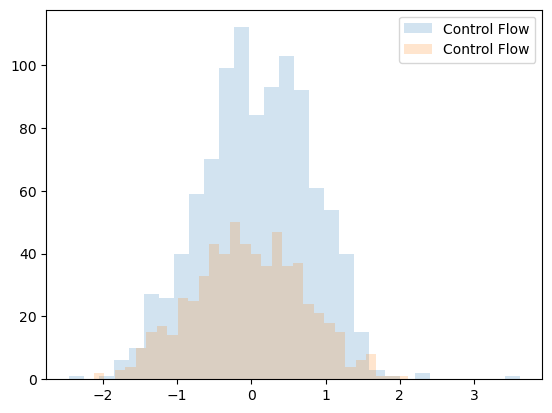

In [8]:
samples_control = location_trans_fitted_flow.sample(key=jr.PRNGKey(3), sample_shape=(1000,), condition=jnp.zeros((1)))
plt.hist(samples_control[:, 0], bins=30, label="Control Flow", alpha=0.2)
plt.hist(Y[X == 0], bins=30, label="Control Flow", alpha=0.2)
plt.legend()

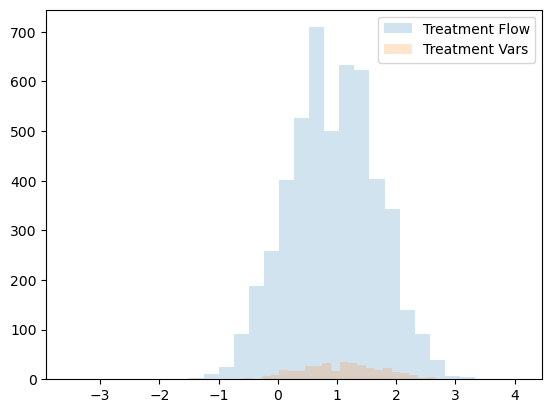

In [9]:
samples_treatment = location_trans_fitted_flow.sample(key=jr.PRNGKey(3), sample_shape=(5000,), condition=jnp.ones((1)))
plt.hist(samples_treatment[:, 0], bins=30, label="Treatment Flow", alpha=0.2)
plt.hist(Y[X == 1], bins=30, label="Treatment Vars", alpha=0.2)
plt.legend()

## Check how to simulate from the outcomes

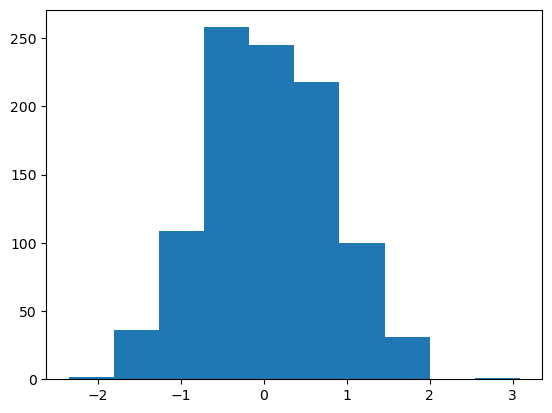

In [10]:
outcome_control_samples = sample_outcome(
    frugal_flow=location_trans_fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=1000,
    causal_model='location_translation',
    causal_condition=jnp.zeros((1000,1)),
    **{'ate': 5}
)
plt.hist(outcome_control_samples);

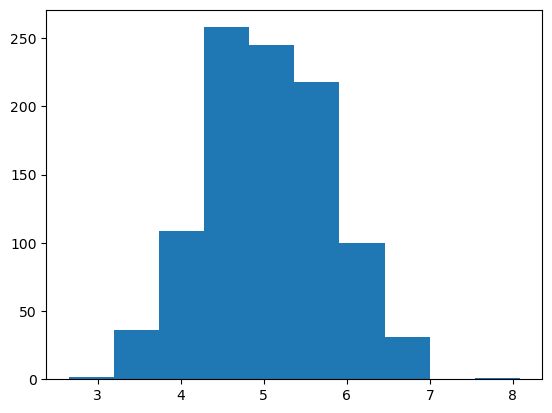

In [11]:
outcome_treatment_samples = sample_outcome(
    frugal_flow=location_trans_fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=1000,
    causal_model='location_translation',
    causal_condition=jnp.ones((1000,1)),
    **{'ate': 5}
)
plt.hist(outcome_treatment_samples);

Very nice! What about if we wanted something discrete?

#### Simulating discrete outcomes

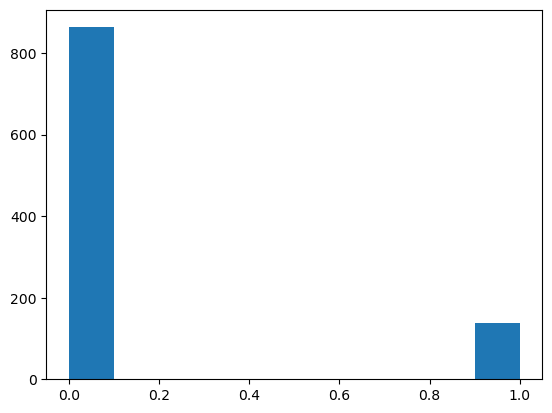

In [12]:
outcome_control_samples = sample_outcome(
    frugal_flow=location_trans_fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=1000,
    causal_model='logistic_regression',
    causal_condition=jnp.zeros((1000,1)),
    **{'ate': 2, 'const': -1}
)
plt.hist(outcome_control_samples.T);

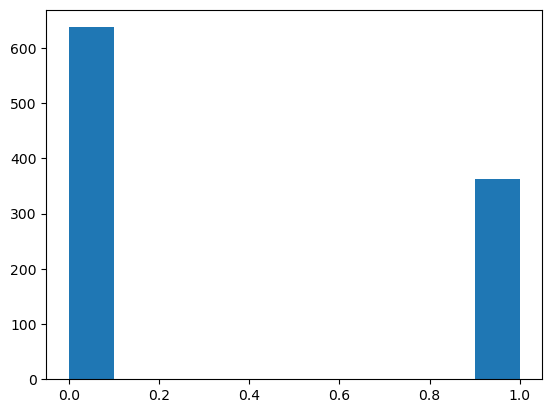

In [13]:
outcome_treatment_samples = sample_outcome(
    frugal_flow=location_trans_fitted_flow,
    affine_to_standard=False,
    key=jr.PRNGKey(10),
    n_samples=1000,
    causal_model='logistic_regression',
    causal_condition=jnp.ones((1000,1)),
    **{'ate': 2, 'const': -1}
)
plt.hist(outcome_treatment_samples.T);

# Testing the $X\mid Z$

### POC Demo

Prop score demo seems to be working!

In [14]:
X_demo = jr.bernoulli(jr.PRNGKey(123), 0.5, (1000,))[:, None].astype(int)
Z_demo = X_demo

prop_flow, losses = train_quantile_propensity_score(
    key=jr.PRNGKey(9),
    x=X_demo,
    condition=Z_demo
)

 55%|██████████████████████████████████████████████████████▍                                            | 55/100 [00:02<00:02, 18.36it/s, train=-0.6383376015856206, val=-0.5915235489829074 (Max patience reached)]


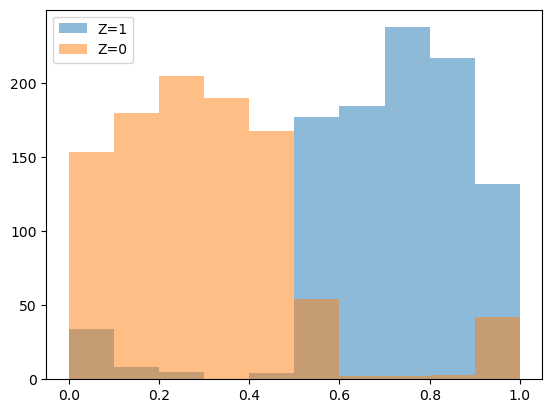

In [15]:
plt.hist(prop_flow.sample(jr.PRNGKey(987), sample_shape=(1000,), condition=jnp.ones((1))).T, label='Z=1', alpha=0.5);
plt.hist(prop_flow.sample(jr.PRNGKey(987), sample_shape=(1000,), condition=jnp.zeros((1))).T, label='Z=0', alpha=0.5);
plt.legend();

### On empirical Data

In [ ]:
prop_flow, losses = train_quantile_propensity_score(
    key=jr.PRNGKey(9),
    x=X.astype(int),
    condition=Z_disc
)

In [ ]:
plt.hist(prop_flow.sample(jr.PRNGKey(987), sample_shape=(5000,), condition=jnp.ones((1))).T, label='Z=1', alpha=0.3);
plt.hist(prop_flow.sample(jr.PRNGKey(987), sample_shape=(5000,), condition=jnp.zeros((1))).T, label='Z=0', alpha=0.3);
plt.legend();

Actual data split is $X\mid Z \sim \text{Bernoulli}(p=\text{Sigmoid}(Z - 1))$, therefore $p \mid Z=1$ equals $0.5$ and $p \mid Z=0$ equals $1/(1 + exp(-1)) = 0.268$.

For the treatment arm:

In [ ]:
(prop_flow.sample(jr.PRNGKey(987), sample_shape=(5000,), condition=jnp.ones((1))) > 0.6).mean()

Bang on! And now for the control:

In [ ]:
(prop_flow.sample(jr.PRNGKey(987), sample_shape=(5000,), condition=jnp.zeros((1))) > 0.6).mean()

Decent enough!